Assignment1 Bandit Problems

Choose a Movie--Hao Fu

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

In [5]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

In [6]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [7]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [9]:
class RandomSampling():
    """
    Random Sampling
    """
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count

    @staticmethod
    def name():
        return 'random'

    def get_action(self):
        # choose a random mechine
        action = np.random.randint(0, self.arm_count)
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret

In [10]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

1.Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important?

Thompson Sampling: don't have hyperparameter. 

E-greedy: epsilon. When epsilon is large, the e-greedy curve converges fast, but its performance is slightly worse. When epsilon is small, the e-greedy curve converges slow, but the performance will be better. 

UCB: constant c. C is larger, Q-value is less important in the choosing. According to the experiments, less c value makes UCB converge faster. But after a while the training will hardly improve. If c value is too large, the training will be too slow.

Random Sampling: don't have hyperarameter.

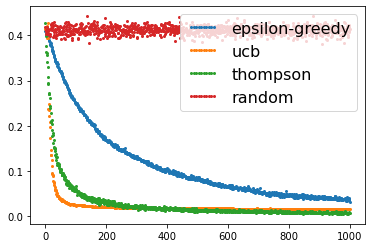

In [11]:
# Experiment 1 
arm_count = 10 # number of arms in bandit
epsilon = 0.02
ucb_c = 0.1
stationary= True
experiment(arm_count)

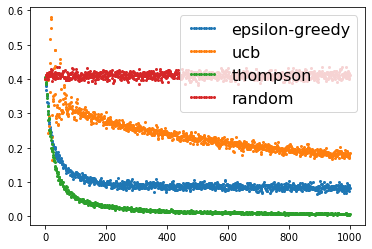

In [12]:
# Experiment 2 
arm_count = 10 # number of arms in bandit
epsilon = 0.2
ucb_c = 3
stationary= True
experiment(arm_count)

2.How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why.

Thompson Sampling: Thompson will optimize more slowly, but still can converge to a low regret level. More action space makes the convergence speed of Thompson sampling slower, but the regret value will be lower, indicating that Thompson sampling is still very reliable, but it takes longer to reach the ideal regret value.

E-greedy: E-greedy has still the quick convergence, but performanse is worse than Thompson. The greedy algorithm need only sample a few values and has a high probability of its most favourable action's estimated reward probability being close to the true optimal reward probability, ensuring it a low regret, even if it never chooses the optimal action.

UCB: UCB is more likely choose those actions who are not the best. In other words, UCB is more likely to try some wrong actions. So it needs more time to select the best choice. So its result is unstable and hardly convergent.

Random Sampling: It doesn't have a big effect, but the regret increasing from 0.4 to 0.5.

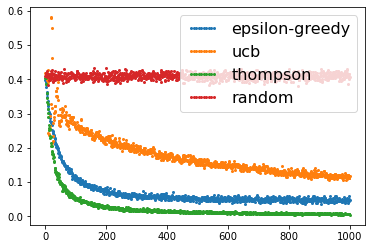

In [13]:
# Experiment 3
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary= True
experiment(arm_count)

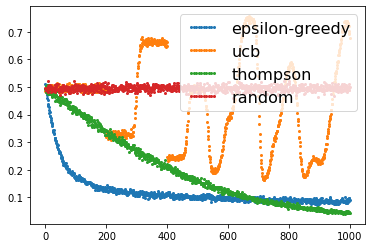

In [14]:
# Experiment 4
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary= True
experiment(arm_count)

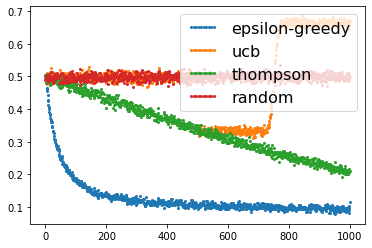

In [17]:
# Experiment 5
arm_count = 500 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary= True
experiment(arm_count)

3.How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. 

Thompson Sampling: Although Thompson Sampling converges quickly. But every time we change the reward distribution, we still have to start to converge again. The result each time is worse than before the change.

E-greedy: The e-greedy algorithm always tries to default the current choice as the best choice, and does not pay attention to the exploration process. When the reward changes over time, it cannot update the selected reward in time, so the result is very poor.

UCB: UCB reacts much more quickly to the non-stationarity, and actually continues to improve in regret over time. No doubt due to its higher emphasis on exploration.

Random Sampling: don't have effect.

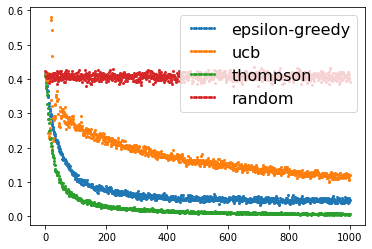

In [18]:
# Experiment 6
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

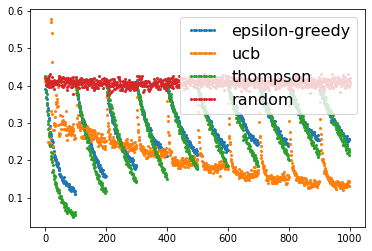

In [19]:
# Experiment 7
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

4.When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff.

Thompson Sampling: If the action corresponding to the maximum value according to the beta distribution is not the last selected action. It begins exploring. If the action corresponding to the obtained maximum value is still the same action, Thompson Sampling stops exploring.

E-greedy: it will stop exploration when the epsilon value becomes 0. Because it simply divide exploration and exploitation. When the random number is less than epsilon, the agent will choose a new mechine to explore. When the random number is larger than epsilon, the agent will choose the best mechine to exploit it.

UCB: If the upper boundary value of the current action is updated, the maximum upper boundary value (() value + confidence value) has changed. It begins exploring. After the update, the action with the maximum value of the upper boundary is still the original action. UCB stops exploring.

Random Sampling: Random sampling will not stop exploration.

5.How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer.

Thompson Sampling: Thompson Sampling remembers the past actions from the beginning. It uses action result to generate beta distributions. And according to the beta distributions, select the next action which has the highest value. And keep doing this.

E-greedy: E-greedy remembers the past actions from the beginning. It uses action result to change the () value. And then it uses the action which has the biggest () value.

UCB: UCB remembers the past actions from the beginning. It calculates the confidence and updates the upper boundary value of current action. Then it select the next action with the biggest upper boundary value.

Random Sampling: Random sampling do not remember the past actions, it pick up action randomly each time.

6.Thompson Sampling with non-Beta distribution. Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)

In [30]:
class BernThompsonNormal():

  # initialize
  def __init__(self, bandit):
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.record = [] 
    self.mean = np.ones(self.arm_count) 
    self.var = np.zeros(self.arm_count) 
    for i in range(0,self.arm_count):
      self.record.append([1]) 

  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.record[arm] = np.append(self.record[arm],reward) # update records
    self.mean[arm] = self.record[arm].mean() # calculate the new mean
    self.var[arm] = self.record[arm].var() # calculate the new variance

  @staticmethod
  def name():
    return 'thompson normal'
  
  def get_action(self):
    theta = np.random.normal(self.mean, self.var) # normal distribution
    return theta.argmax()

def experimentModify(arm_count, timesteps=1000, simulations=1000):
    algos = [EpsilonGreedy, UCB, BernThompsonNormal, RandomSampling]
    regrets = []
    names = []
    for algo in algos:
      regrets.append(simulate(simulations, timesteps, arm_count, algo))
      names.append(algo.name())
    multi_plot_data(regrets, names)

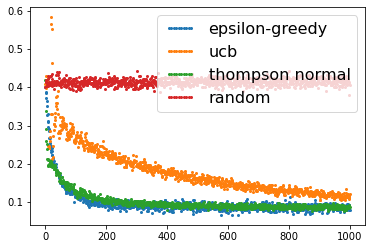

In [31]:
# Experiment 8
arm_count = 10 # number of arms in bandit
epsilon = 0.2
ucb_c = 2
stationary= True
experimentModify(arm_count)

7.What code is yours and what have you adapted?

I create a new random sampling class and a thompson sampling class with normal distribution. Base on the problem, I create two experiment control group to display the result.

8.Did I explain my licensing clearly? 

MIT License

Copyright (c) 2022 Hao Fu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.